In [48]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from kan import KAN
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import time
# from my_utils import *

torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [1011]:

# 1. Generate synthetic data
np.random.seed(42)
N = 1200
x1 = np.random.uniform(-1, 1, N)
x2 = np.random.uniform(-1, 1, N)
epsilon = np.random.normal(0, 0.05, N)
y = np.sin(np.pi * x1 * x2) + np.cos(2 * np.pi * x1) + 0.5 * x2**2 + epsilon

X = np.stack((x1, x2), axis=1)
y = y.reshape(-1, 1)

# 2. Split and normalize
X_train, X_test, y_train, y_test_true = train_test_split(X, y, test_size=0.2)
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train = scaler_X.transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.transform(y_train)
y_test = scaler_y.transform(y_test_true)

# Convert them to torch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

dataset = {}
dataset['train_input'] = X_train_tensor.to(device)
dataset['test_input'] = X_test_tensor.to(device)
dataset['train_label'] = y_train_tensor.to(device)
dataset['test_label'] = y_test_tensor.to(device)

loss_fn = nn.MSELoss()

In [1012]:
# create a KAN: 2D inputs, 1D output, and 1 hidden neurons. cubic spline (k=3), 3 grid intervals (grid=3).
kan_model = KAN(width=[2,3,1], grid=5, k=3, seed=42, device=device)

checkpoint directory created: ./model
saving model version 0.0


In [1013]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            # nn.Linear(16, 16),
            # nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.model(x)

mlp = MLP().to(device)

In [1014]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# For MLP:
mlp_param_count = count_trainable_params(mlp)
print(f"MLP trainable parameters: {mlp_param_count}")

# For KAN:
kan_param_count = count_trainable_params(kan_model)
print(f"KAN trainable parameters: {kan_param_count}")


MLP trainable parameters: 257
KAN trainable parameters: 126


In [1015]:
# Epoch = [i for i in range(0,80)]
# mse =[]
# mae =[]
# r2 = []
# for epoch in Epoch:
#     result = kan_model.fit(dataset, steps=1, opt="LBFGS", loss_fn=loss_fn,  batch=64)
#     kan_model.train(False)
#     kan_pred = kan_model(dataset['test_input']).detach().cpu()
#     kan_pred_rescaled = scaler_y.inverse_transform(kan_pred)
#     mse.append(round(mean_squared_error(y_test_true, kan_pred_rescaled),4))
#     mae.append(round(mean_absolute_error(y_test_true, kan_pred_rescaled),4))
#     r2.append(round(r2_score(y_test_true, kan_pred_rescaled),4))


In [1016]:
# kan_model = KAN(width=[2,3,1], grid=3, k=3, seed=42, device=device)
kan_model = KAN(width=[2,3,1], grid=5, k=3, seed=42, device=device)
start_mlp = time.time()
result = kan_model.fit(dataset, steps=50, opt="LBFGS", loss_fn=loss_fn,  batch=64)   
kan_time = time.time() - start_mlp
round(kan_time,4)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.37e-02 | test_loss: 9.69e-02 | reg: 1.21e+01 | : 100%|█| 50/50 [00:16<00:00,  3.03it

saving model version 0.1


16.5377

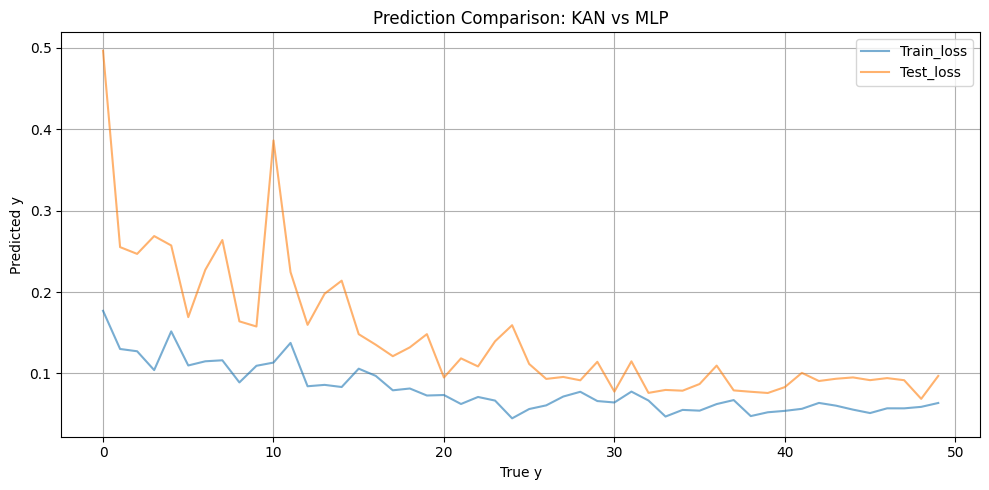

In [1017]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(result['train_loss'], label="Train_loss", alpha=0.6)
plt.plot(result['test_loss'], label="Test_loss", alpha=0.6)

plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.legend()
plt.title("Prediction Comparison: KAN vs MLP")
plt.grid(True)
plt.tight_layout()
plt.show()

In [1018]:
# import matplotlib.pyplot as plt
# fig, axs = plt.subplots(1, 3, figsize=(18, 4))

# axs[0].plot(Epoch, mse, label="MSE", color='blue')
# axs[0].set_title("Mean Squared Error")
# axs[0].set_xlabel("Epoch")
# axs[0].set_ylabel("MSE")
# axs[0].grid(True)

# axs[1].plot(Epoch, r2, label="R²", color='green')
# axs[1].set_title("R² Score")
# axs[1].set_xlabel("Epoch")
# axs[1].set_ylabel("R²")
# axs[1].grid(True)

# axs[2].plot(Epoch, mae, label="MAE", color='red')
# axs[2].set_title("Mean Absolute Error")
# axs[2].set_xlabel("Epoch")
# axs[2].set_ylabel("MAE")
# axs[2].grid(True)

# plt.suptitle("KAN Performance Metrics Over Epochs", fontsize=14)
# plt.tight_layout()
# plt.savefig("image/KAN_2.pdf")
# plt.show()

In [1019]:
train_dataset = TensorDataset(X_train_tensor.to(device),y_train_tensor.to(device))
train_loader  = DataLoader(train_dataset,batch_size=64, shuffle=True)


In [1020]:
mlp = MLP().to(device)
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)

mse =[]
mae =[]
r2 = []
for epoch in range(200):
    for x_batch,y_batch in train_loader:        
        mlp.train()
        y_pred = mlp(x_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [1021]:
mlp.eval()
with torch.no_grad():
    mlp_pred = mlp(X_test_tensor.to(device)).detach().cpu()
mlp_pred_rescaled = scaler_y.inverse_transform(mlp_pred)

kan_model.train(False)
kan_pred = kan_model(dataset['test_input']).detach().cpu()
kan_pred_rescaled = scaler_y.inverse_transform(kan_pred)

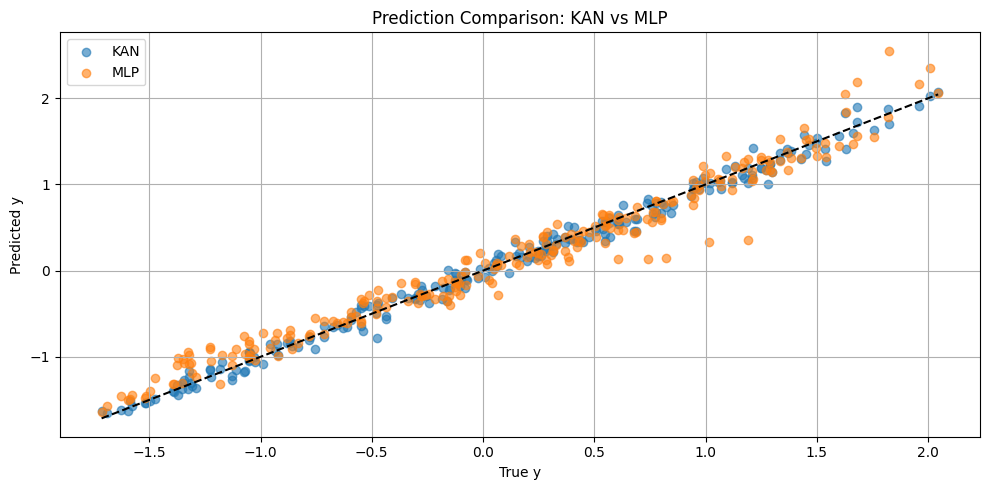

In [1029]:
# Plot results
plt.figure(figsize=(10, 5))
plt.scatter(y_test_true, kan_pred_rescaled, label="KAN", alpha=0.6)
plt.scatter(y_test_true, mlp_pred_rescaled, label="MLP", alpha=0.6)
plt.plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], 'k--')
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.legend()
plt.title("Prediction Comparison: KAN vs MLP")
plt.grid(True)
plt.tight_layout()
plt.savefig("image/scatter.pdf")
plt.show()


In [1030]:
# Create a meshgrid for visualization
grid_size = 100
x1_lin = np.linspace(-1, 1, grid_size)
x2_lin = np.linspace(-1, 1, grid_size)
xx, yy = np.meshgrid(x1_lin, x2_lin)
X_grid = np.stack([xx.ravel(), yy.ravel()], axis=1)

# Compute true surface
epsilon_grid = np.zeros_like(X_grid[:, 0])  # No noise for visualization
true_surface = (
    np.sin(np.pi * X_grid[:, 0] * X_grid[:, 1])
    + np.cos(2 * np.pi * X_grid[:, 0])
    + 0.5 * X_grid[:, 1] ** 2
)

# Normalize the grid using training scalers
X_grid_scaled = scaler_X.transform(X_grid)

# KAN prediction
with torch.no_grad():
    kan_surface = kan_model(torch.tensor(X_grid_scaled).to(device)).cpu().numpy().squeeze()

# MLP prediction
with torch.no_grad():
    mlp_surface = mlp(torch.tensor(X_grid_scaled).to(device)).cpu().numpy().squeeze()

# Rescale predictions
kan_surface = scaler_y.inverse_transform(kan_surface.reshape(-1, 1)).reshape(grid_size, grid_size)
mlp_surface = scaler_y.inverse_transform(mlp_surface.reshape(-1, 1)).reshape(grid_size, grid_size)
true_surface = true_surface.reshape(grid_size, grid_size)


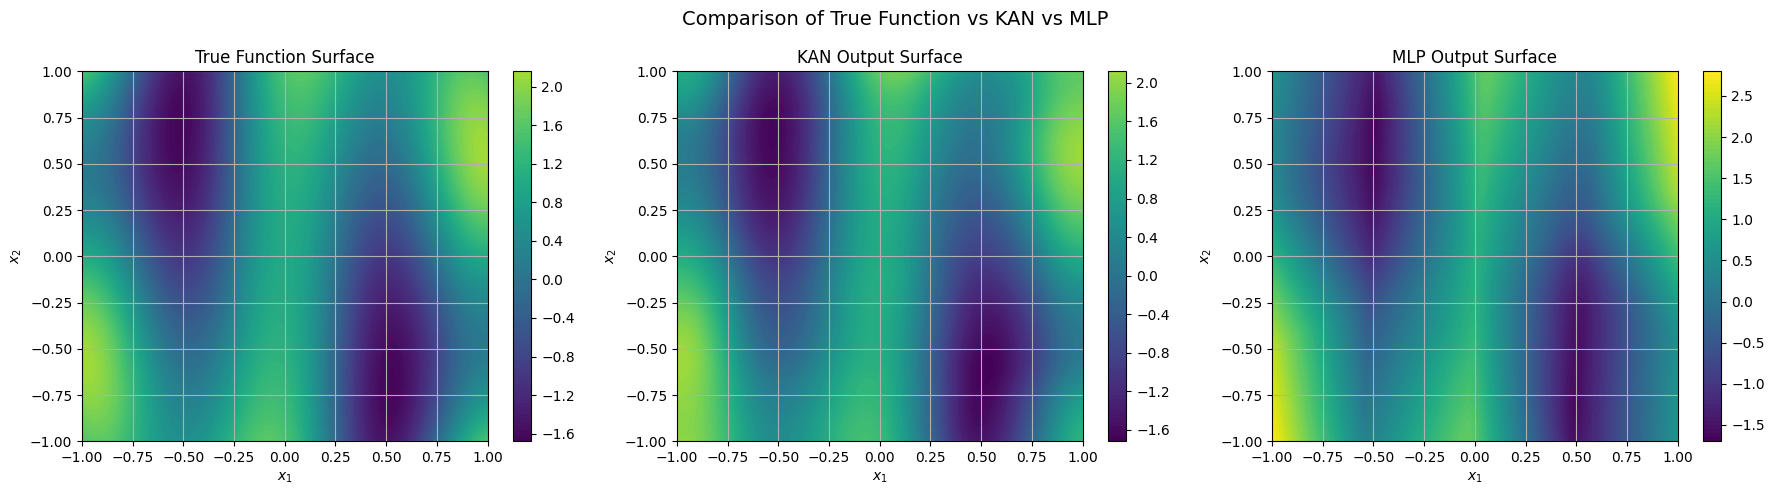

In [1032]:
# Determine common color scale limits
vmin = min(true_surface.min(), kan_surface.min(), mlp_surface.min())
vmax = max(true_surface.max(), kan_surface.max(), mlp_surface.max())

# Plot all three surfaces with shared color scale
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# True Surface
cs0 = axs[0].contourf(xx, yy, true_surface, levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title('True Function Surface')
fig.colorbar(cs0, ax=axs[0])

# KAN Surface
cs1 = axs[1].contourf(xx, yy, kan_surface, levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title('KAN Output Surface')
fig.colorbar(cs1, ax=axs[1])

# MLP Surface
cs2 = axs[2].contourf(xx, yy, mlp_surface, levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
axs[2].set_title('MLP Output Surface')
fig.colorbar(cs2, ax=axs[2])

# Styling
for ax in axs:
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.grid(True)

plt.suptitle("Comparison of True Function vs KAN vs MLP", fontsize=14)
plt.tight_layout()
plt.savefig("image/surface.pdf")
plt.show()


In [1025]:
print(f"Training Time (KAN): {kan_time:.2f} seconds")
print(f"Training Time (MLP): {mlp_time:.2f} seconds")

Training Time (KAN): 16.54 seconds
Training Time (MLP): 4.08 seconds


In [1026]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to compute all regression metrics
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {
        'MSE': mse,
        'MAE': mae,
        'R^2': r2,
    }

In [1027]:
# Compute metrics
kan_metrics = compute_metrics(y_test_true, kan_pred_rescaled)
mlp_metrics = compute_metrics(y_test_true, mlp_pred_rescaled)

In [1028]:
# Print results
print("Performance Metrics:")
print("\nKAN:")
for k, v in kan_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nMLP:")
for k, v in mlp_metrics.items():
    print(f"{k}: {v:.4f}")

Performance Metrics:

KAN:
MSE: 0.0082
MAE: 0.0715
R^2: 0.9906

MLP:
MSE: 0.0325
MAE: 0.1291
R^2: 0.9627
